In [1]:
import pandas as pd
from gensim.models import word2vec
import pickle
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# Importing the previously generated dataset

In [2]:
with open("data/clean_recipes.pkl", "rb") as f:
    df = pickle.load(f)

# Vectorizing

## Training the model

In [3]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum occurence of words               
num_workers = 4       # Number of CPUs
context = 15          # Context window size; 
downsampling = 1e-2   # threshold for configuring which higher-frequency words are randomly downsampled
            
# Initialize and train the model 
model = word2vec.Word2Vec(df["clean_ingredients"],
                          workers=num_workers, 
                          vector_size=num_features, 
                          min_count=min_word_count, 
                          window=context,
                          sample=downsampling)

model.init_sims(replace=True)
# According to the documentation, calling init_sims(replace=True) makes the model much more memory-efficient.
# But, it also makes the model read-only, so you can't train it any further.
# If you want to train it further, call init_sims(replace=False) instead.
# However, this is going to be deprecated in the future. It is recommended to use train the model differently instead. Cf. https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

C:\Users\remS\AppData\Local\Temp\ipykernel_20276\3335554428.py:15: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


## Exploring similarities based on the wv (word vectors)

### Getting the most similar ingredients to an inputed one

In [4]:
model.wv.most_similar('poulet')

[('dinde', 0.897466242313385),
 ('viande de dinde', 0.8300706744194031),
 ('viande de poulet', 0.7884366512298584),
 ('foie de volaille', 0.7438839673995972),
 ('viande de volaille', 0.7315109372138977),
 ('canard', 0.6951792240142822),
 ('bouillon de poulet', 0.67788165807724),
 ('bouillon de volaille', 0.6650865077972412),
 ('bouillon', 0.6494567394256592),
 ('peau de volaille', 0.6337999105453491)]

### Creating a dictionnary of search terms

In [5]:
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)] 
                 for search_term in ['sel','melon','olive', 'chocolat', 'oignon']}

# Associate a color to each ingredient
similar_words

{'sel': ['sel de mer iodé',
  'pâte de soja',
  'fromage romano au lait de vache',
  'basilic séché',
  'huile de tournesol désodorisée'],
 'melon': ['confits de melon', 'papaye', 'nectarine', 'figure', 'pastèque'],
 'olive': ['olive verte', 'wasabi', 'ortie', 'genévrier', 'banane plantain'],
 'chocolat': ['le beurre de cacao',
  'pâte de cacao',
  'morceau de chocolat',
  'poudre de cacao',
  'chocolat noir'],
 'oignon': ['en proportion variable',
  'patate douce',
  'échalote',
  "mélange d'huile",
  'raifort']}

## Viz

In [6]:
# Create a list of 5 colors that are repeated 6 times (one for each ingredient)
cols = ['red', 'blue', 'green', 'orange', 'purple']
colors = [col for col in cols for i in range(6)]

c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


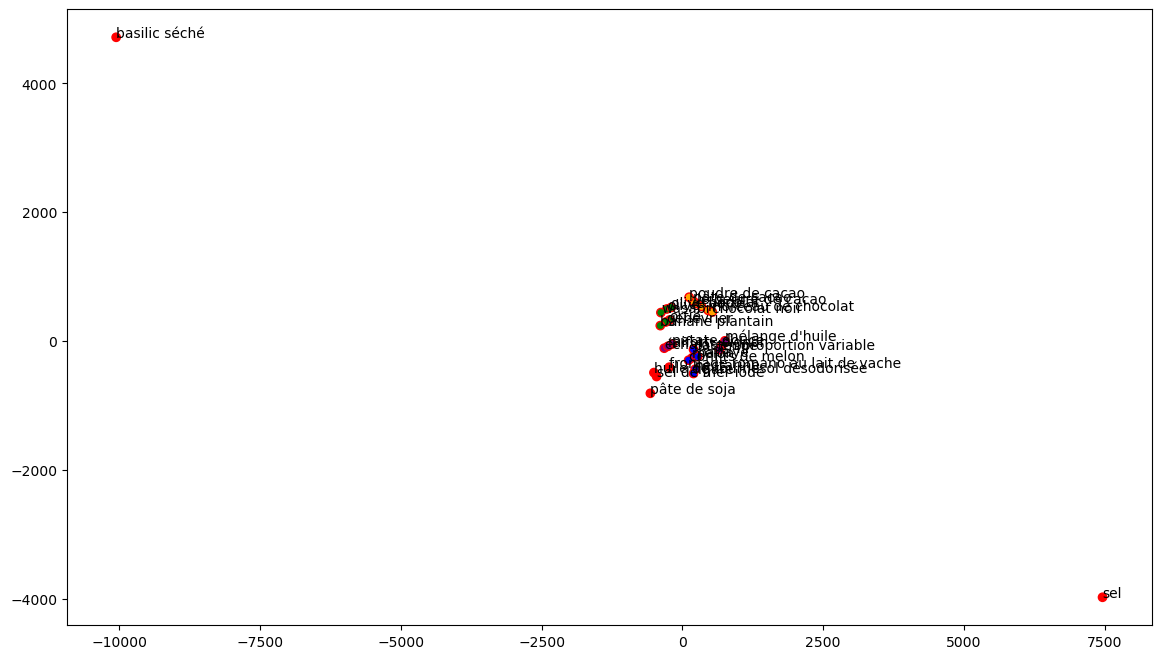

In [7]:
#visualization with Tsne
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Computing product embeddings

In [8]:
def compute_embedding(ingredients):
    embedding = np.zeros(num_features) # Initialize the embedding with zeros (n dimensions)
    for ing in ingredients: # For each ingredient in the recipe
        embedding += model.wv[ing] # Add the ingredient's embedding to the recipe's embedding
    return embedding / len(ingredients) # Return the average embedding

In [9]:
# Compute the embedding for each recipe
recipe_embeddings = []
for recipe in df['clean_ingredients']:
    recipe_embeddings.append(compute_embedding(recipe))
df['recipe_embedding'] = recipe_embeddings

# Visualize the embeddings

## All

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from mpl_toolkits import mplot3d

# Reduce the dimensionality of the embeddings to 3 using PCA, UMAP and t-SNE
pca_3D = PCA(n_components=3)
pca_2D = PCA(n_components=2)
tsne_3D = TSNE(n_components=3, random_state=0, n_iter=1000, perplexity=2)
tsne_2D = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
umap_3D = umap.UMAP(n_components=3, random_state=0, n_neighbors=15, min_dist=0.1)
umap_2D = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)

In [11]:
embeddings = np.array(df['recipe_embedding'].tolist())
print("Computing PCA ")
# embeddings_pca_3d = pca_3D.fit_transform(embeddings)
embeddings_pca_2d = pca_2D.fit_transform(embeddings)
# print("Computing t-SNE")
# embeddings_tsne_3d = tsne_3D.fit_transform(embeddings)
# embeddings_tsne_2d = tsne_2D.fit_transform(embeddings)
# print("Computing UMAP")
# embeddings_umap_3d = umap_3D.fit_transform(embeddings) 
# embeddings_umap_2d = umap_2D.fit_transform(embeddings)

Computing PCA 


Text(0.5, 1.0, 'PCA 2D')

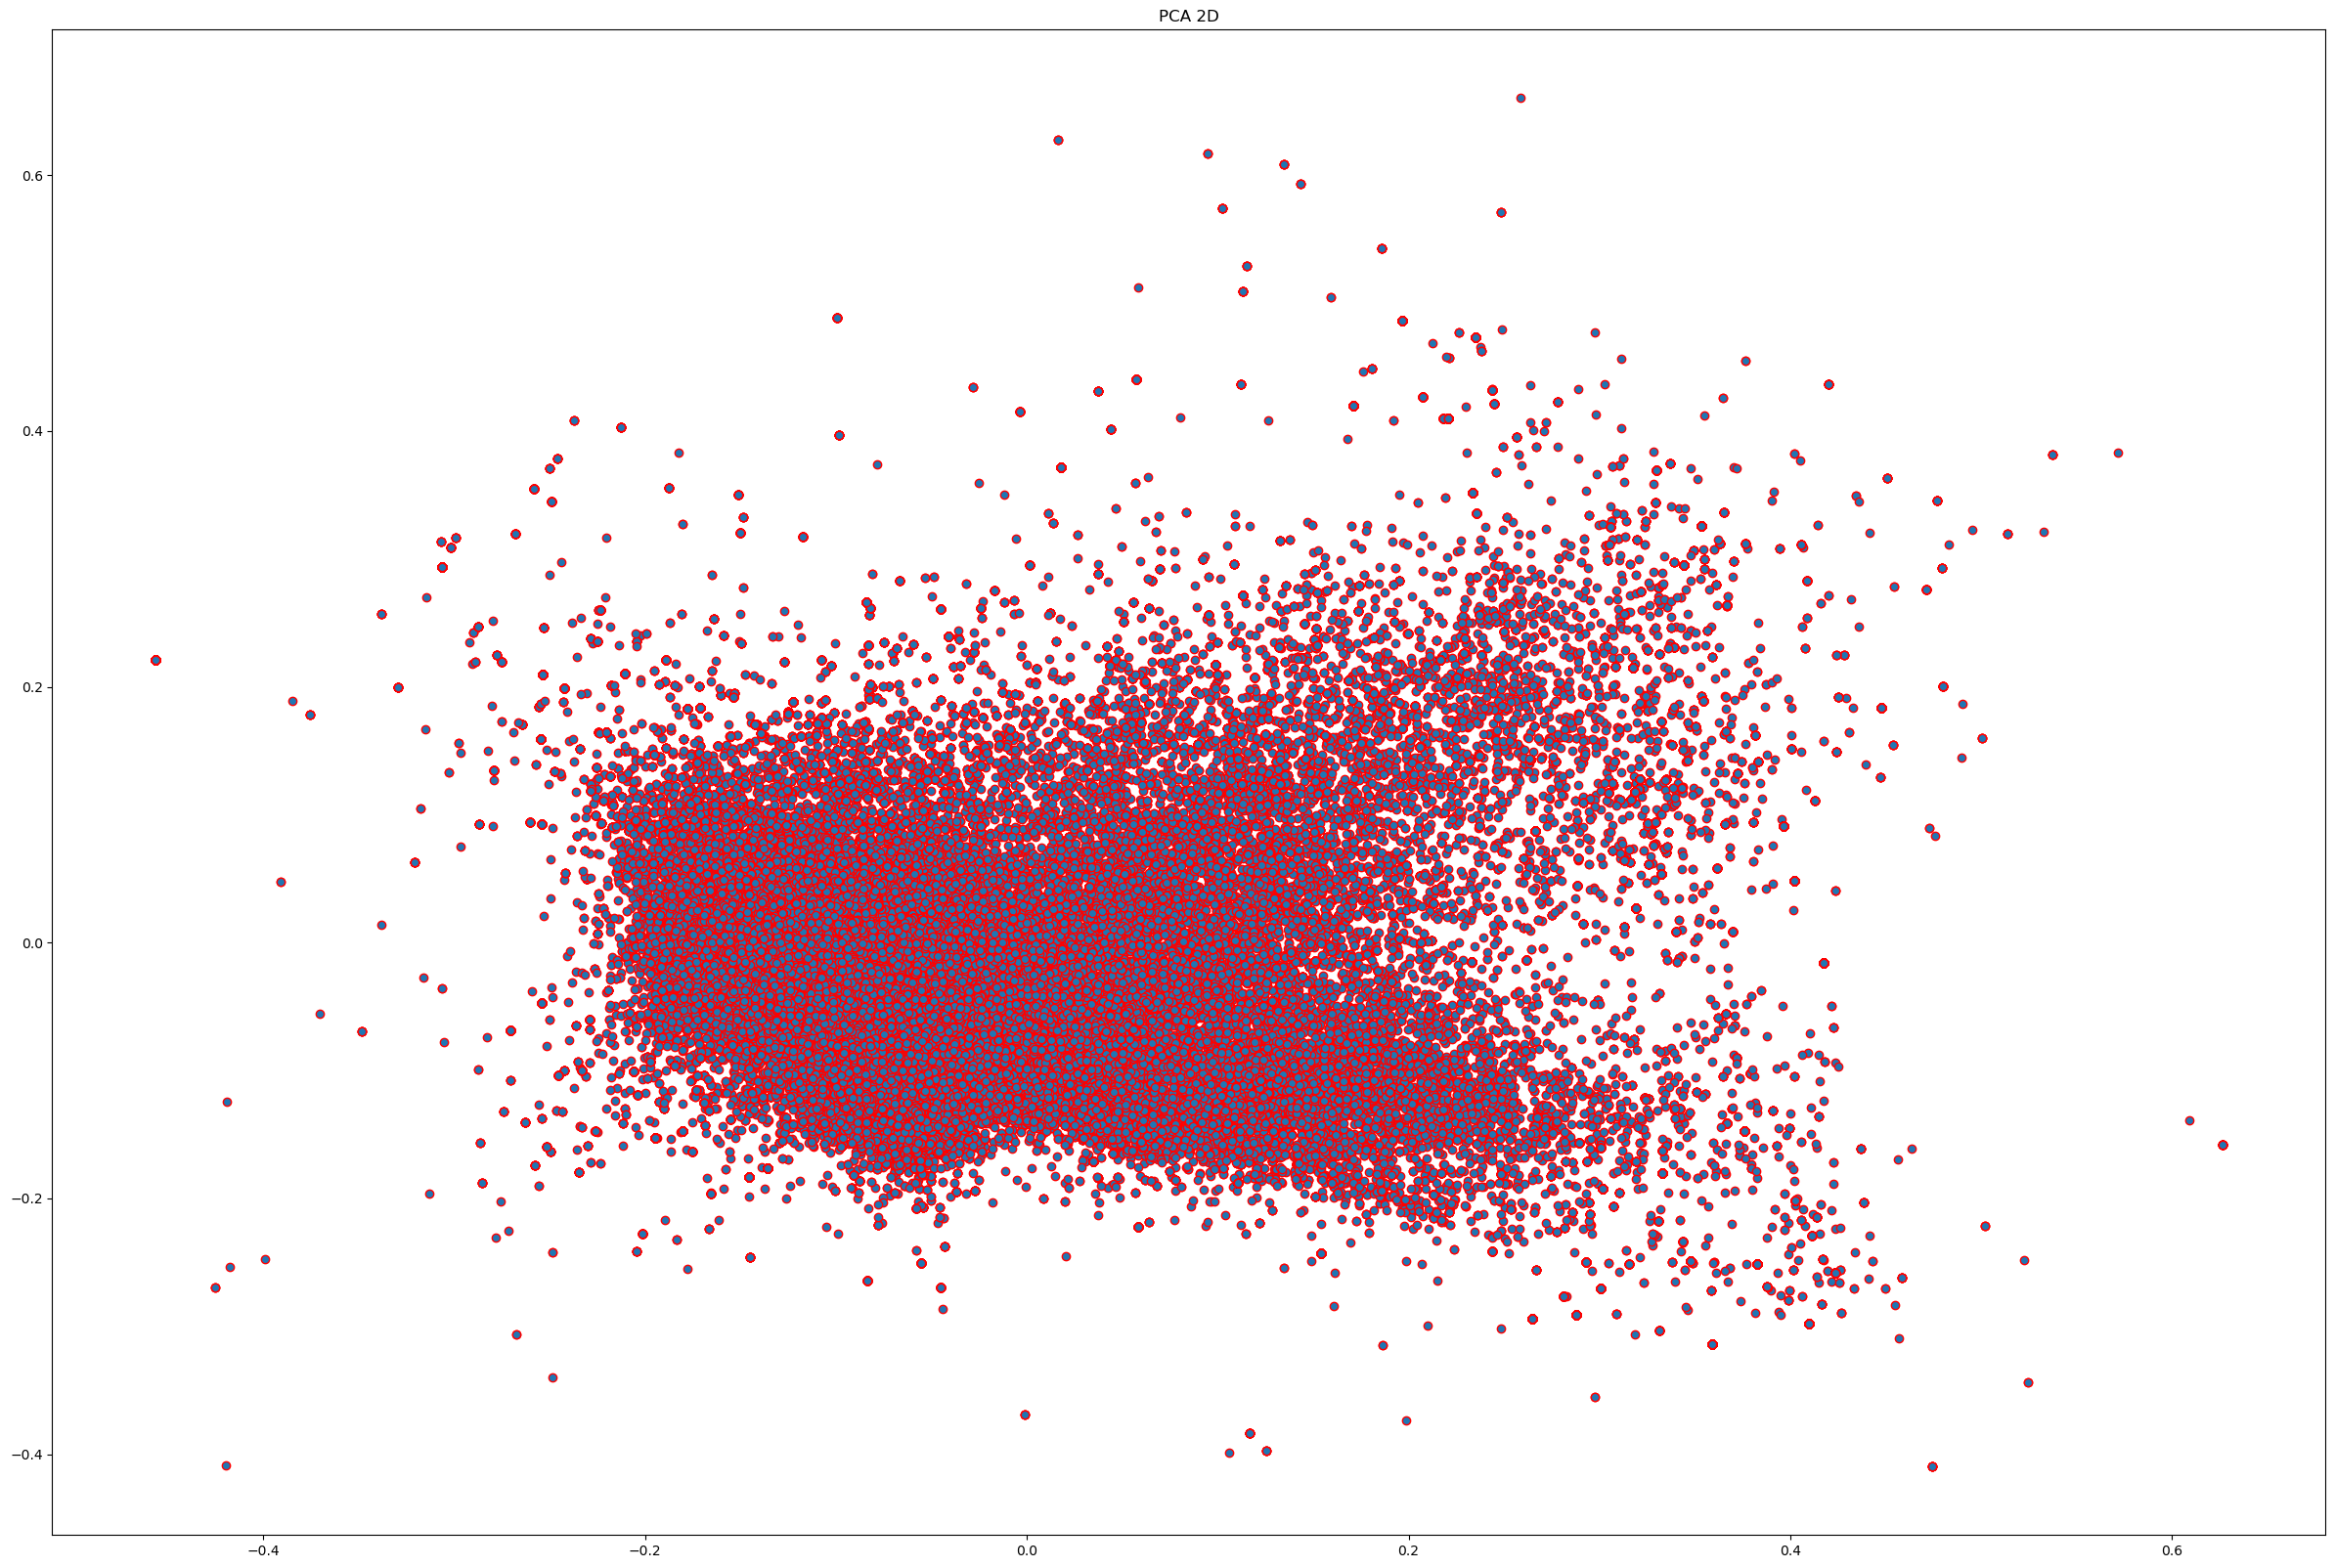

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(30, 20))

# Plot the PCA with the name of the product as label 
axs.scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], edgecolors='r') 
axs.set_title('PCA 2D')

In [13]:
# Get all categories and their corresponding count
categories = df['main_category_en'].value_counts()

# Filter out the categories that have less than 1000 recipes
categories = categories[categories > 1000]

# Filter out the recipes that are not in the categories that have more than 1000 recipes
df_reduced = df[df['main_category_en'].isin(categories.index)]

print("Number of interesting categories: ", len(categories))

Number of interesting categories:  15


In [14]:
pca_2d_filtered = pca_2D.fit_transform(np.array(df_reduced['recipe_embedding'].tolist()))

## Top categories only

Text(0.5, 1.0, 'PCA 2D of the categories with more than 1000 recipes')

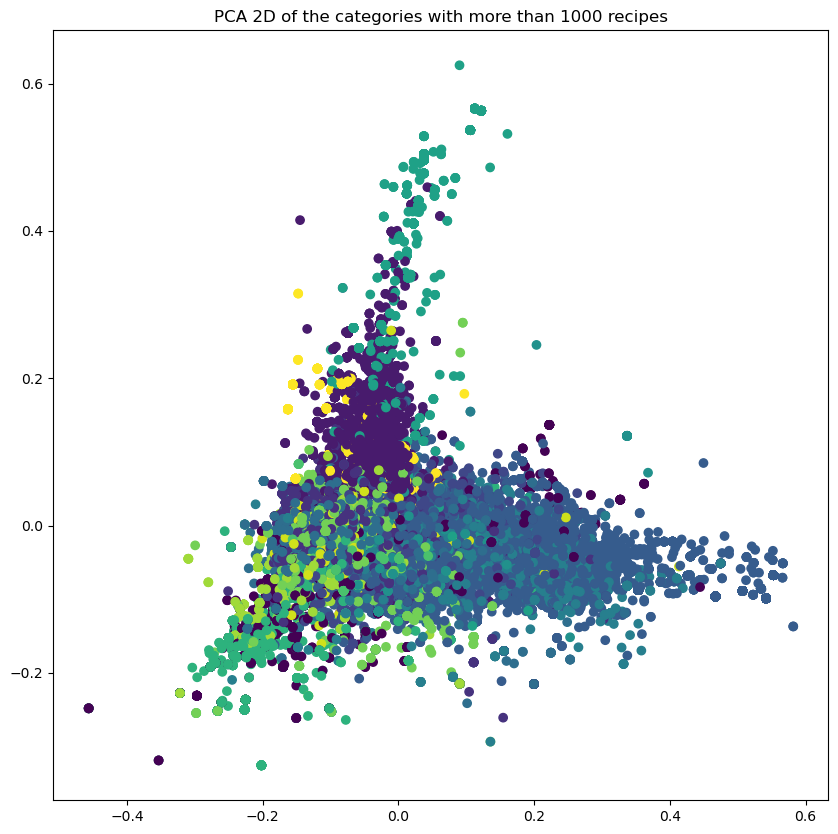

In [15]:
# Plot the PCA of the items in df_reduced colored by their category
fig, axs = plt.subplots(1, 1, figsize=(10, 10)) 
axs.scatter(pca_2d_filtered[:, 0], pca_2d_filtered[:, 1], c=df_reduced['main_category_en'].factorize()[0])
axs.set_title('PCA 2D of the categories with more than 1000 recipes')

# Clustering

We will now focus our study on those categories. Our goal is to see if our kmeans matches with the real product categories.

## K-means

In [16]:
# Do a k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(df_reduced['recipe_embedding'].to_list())
df_reduced['kmeans_cluster'] = kmeans.labels_

C:\Users\remS\AppData\Local\Temp\ipykernel_20276\764086339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['kmeans_cluster'] = kmeans.labels_


## DBScan

In [17]:
# Do a DBSCAN on the embeddings
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.1, min_samples=5).fit(df_reduced['recipe_embedding'].tolist())
df_reduced['dbscan_cluster'] = clustering.labels_

# Filter out the clusters that are noise
df_reduced_db = df_reduced[df_reduced['dbscan_cluster'] != -1]

# Compute the PCA of these clusters
pca_2d_filtered_db = pca_2D.fit_transform(np.array(df_reduced_db['recipe_embedding'].tolist()))

C:\Users\remS\AppData\Local\Temp\ipykernel_20276\3791951318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['dbscan_cluster'] = clustering.labels_


## Hierarchical clustering

In [18]:
# Do a hierarchical clustering
from sklearn.cluster import AgglomerativeClustering 
 
clustering = AgglomerativeClustering(n_clusters=15).fit(df_reduced['recipe_embedding'].tolist())
df_reduced['hierarchical_cluster'] = clustering.labels_

C:\Users\remS\AppData\Local\Temp\ipykernel_20276\1107717250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['hierarchical_cluster'] = clustering.labels_


In [19]:
print("Number of recipes:", len(df_reduced))
print("Number of categories:", len(df_reduced['main_category_en'].unique()))

print("Number of clusters with DBScan:", len(set(clustering.labels_)))
print("Number of recipes in the largest cluster with DBScan:", max([len(df_reduced_db[df_reduced_db['dbscan_cluster'] == i]) for i in set(df_reduced_db['dbscan_cluster'])]))
print("Number of recipes in the smallest cluster with DBScan:", min([len(df_reduced_db[df_reduced_db['dbscan_cluster'] == i]) for i in set(df_reduced_db['dbscan_cluster'])]))
print("Average number of recipes per cluster with DBScan:", len(df_reduced) / len(set(df_reduced_db['dbscan_cluster'])))

Number of recipes: 31570
Number of categories: 15
Number of clusters with DBScan: 15
Number of recipes in the largest cluster with DBScan: 1228
Number of recipes in the smallest cluster with DBScan: 2
Average number of recipes per cluster with DBScan: 43.60497237569061


# Plotting

## 2D

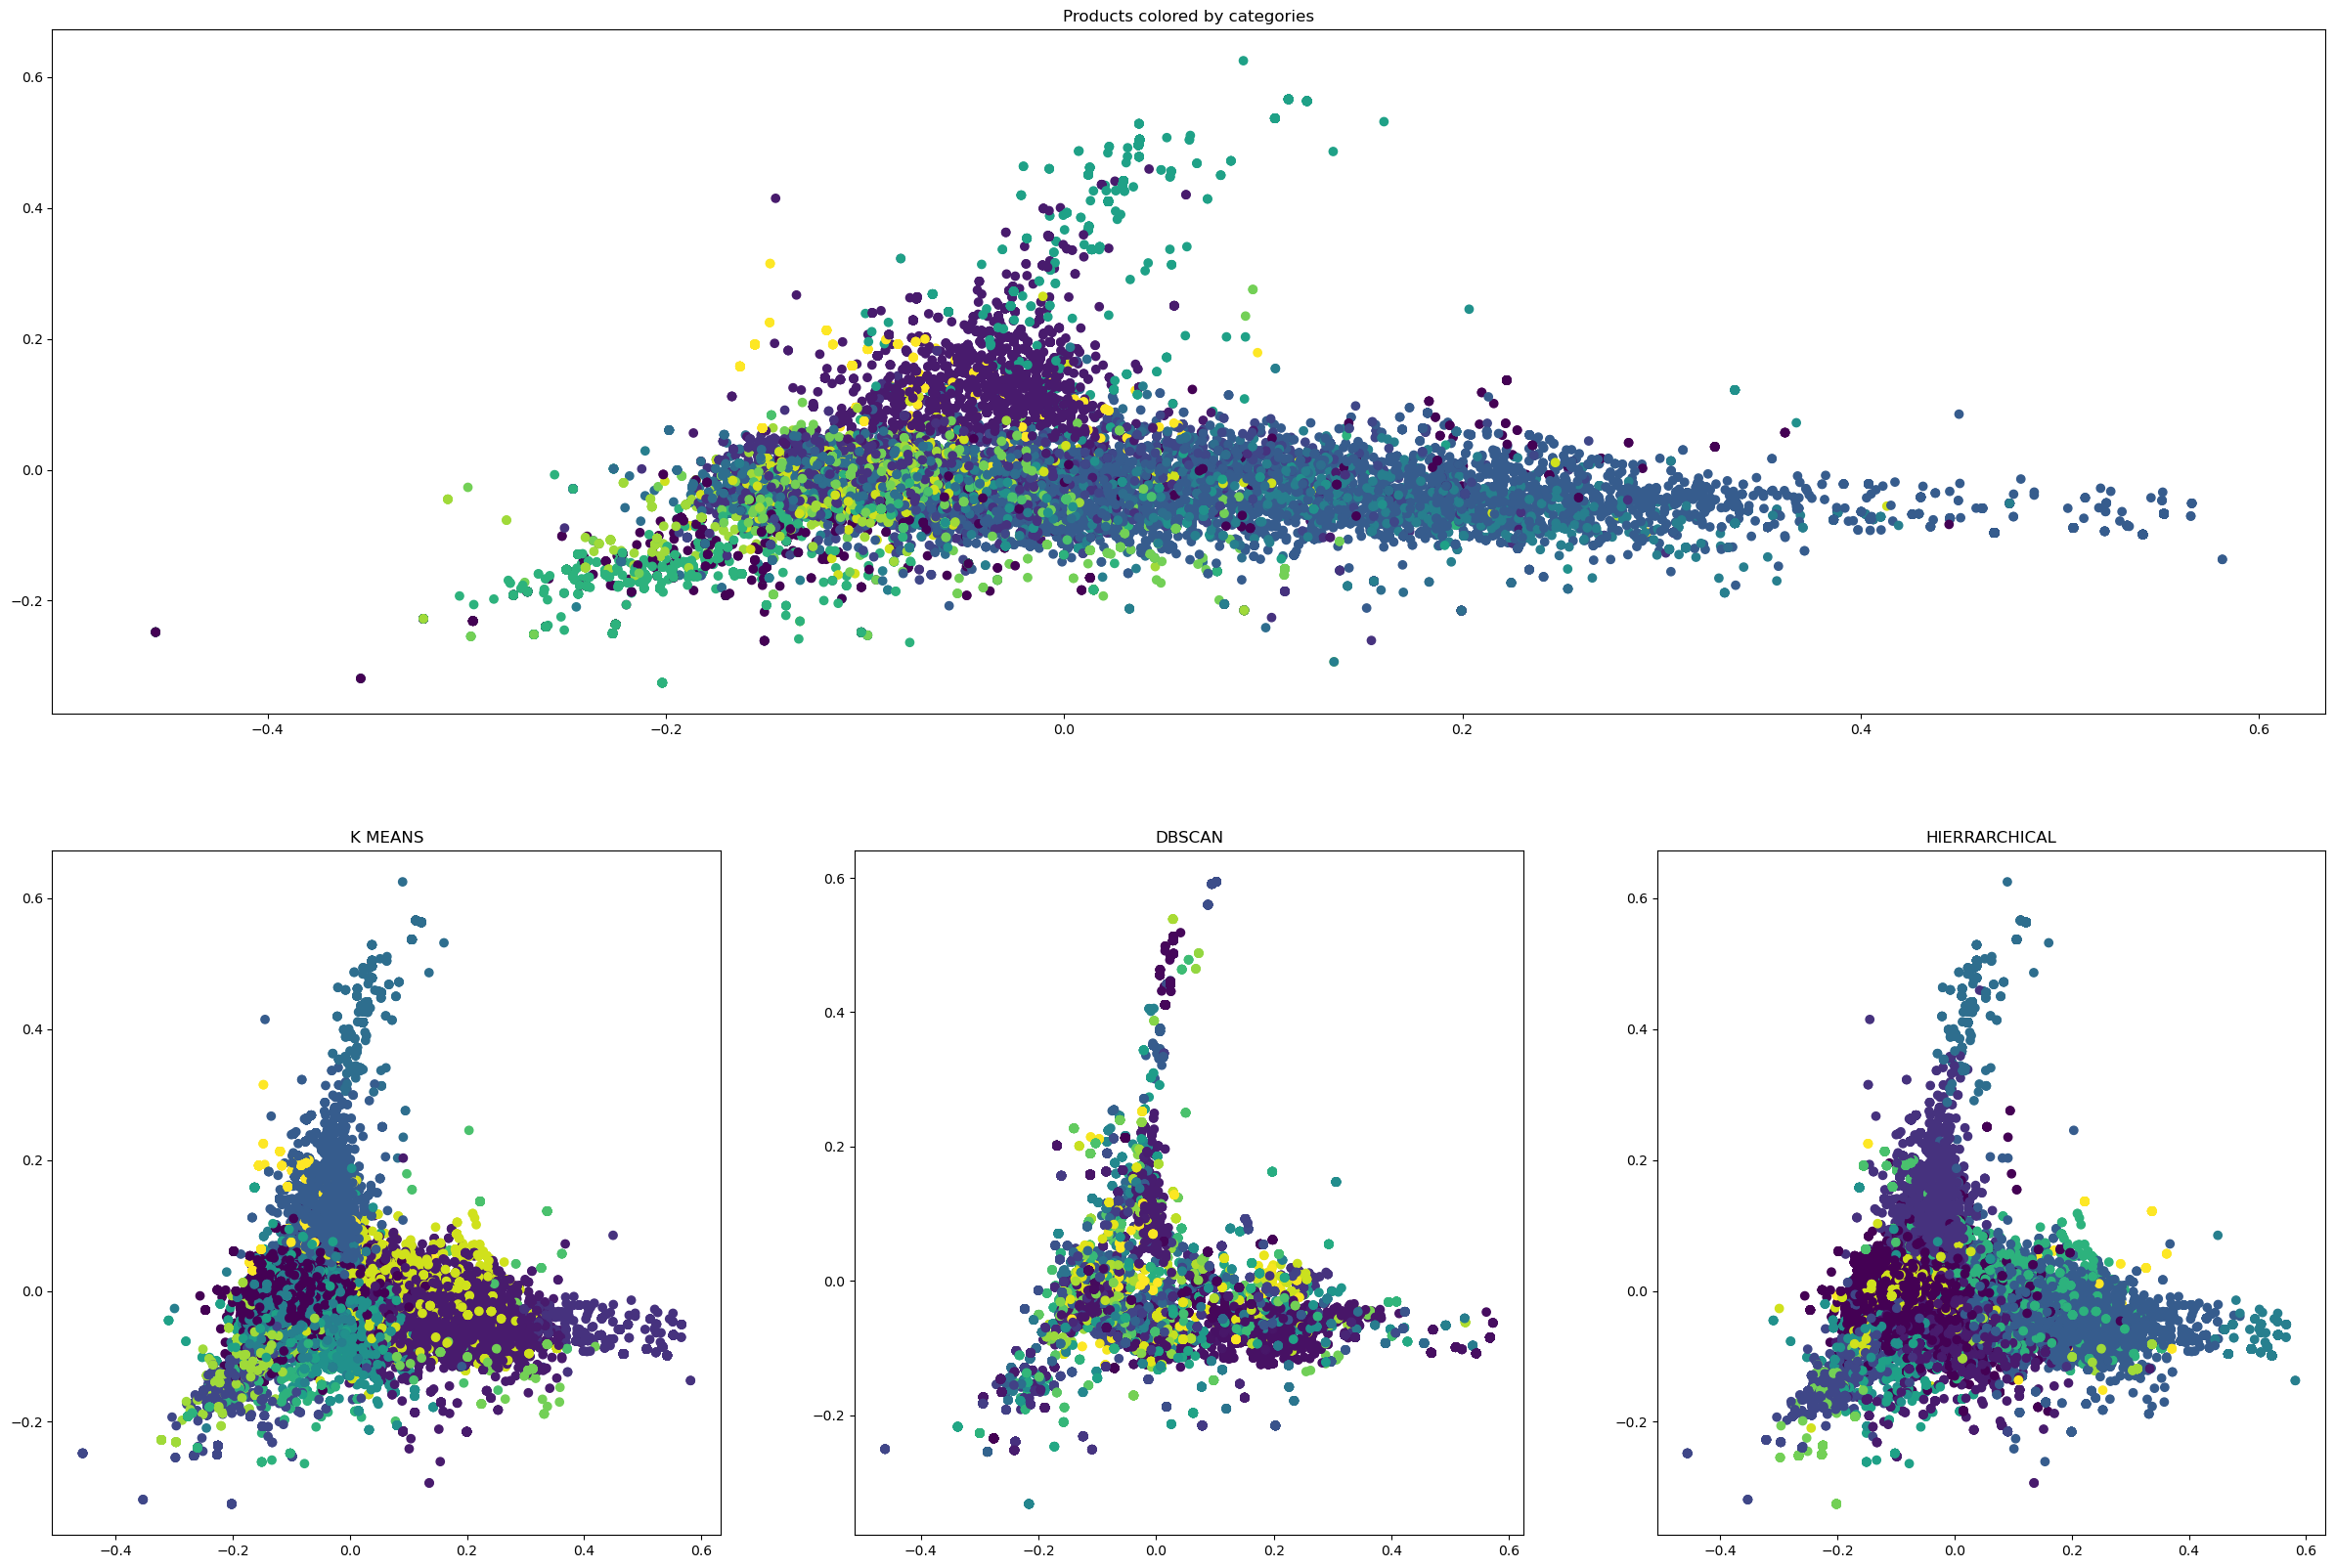

In [20]:
# Create a figure with 2 columns
# Create a subfigure in the second column with 3 rows
fig = plt.figure(figsize=(30, 20))

gs = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[1, 2]) 

# Plot the original PCA colored by the category that takes the full first column
ax0.scatter(pca_2d_filtered[:, 0], pca_2d_filtered[:, 1], c=df_reduced['main_category_en'].factorize()[0])
ax0.set_title('Products colored by categories')
 
# Plot the PCA colored by the k-means cluster
ax1.scatter(pca_2d_filtered[:, 0], pca_2d_filtered[:, 1], c=df_reduced['kmeans_cluster'])
ax1.set_title('K MEANS')

# Plot the PCA colored by the DBSCAN cluster
ax2.scatter(pca_2d_filtered_db[:, 0], pca_2d_filtered_db[:, 1], c=df_reduced_db['dbscan_cluster'])
ax2.set_title('DBSCAN')

# Plot the hierarchical clustering
ax3.scatter(pca_2d_filtered[:, 0], pca_2d_filtered[:, 1], c=df_reduced['hierarchical_cluster'])
ax3.set_title('HIERRARCHICAL')

plt.show()

# Most similar products

In [21]:
def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [26]:
def get_similar_products(selected_product, df, n=10):
    # Lower the name of products
    df['product_name'] = df['product_name'].str.lower()
     
    # Get the embedding of the selected product
    selected_product_embedding = df[df['product_name'] == selected_product.lower()]['recipe_embedding'].values[0]
    
    # Compute the cosine similarity between the selected product and all the other products
    df['similarity'] = df['recipe_embedding'].apply(lambda x: 1 - cosine_distance(x, selected_product_embedding))
    
    # Sort the dataframe by similarity
    df_sorted = df.sort_values(by=['similarity'], ascending=False)
    
    # Return the n most similar products
    return df_sorted[['product_name', 'similarity', 'clean_ingredients']][:n]

In [33]:
n_similar_products = 20
selected_product = "jus multifruits"
try:
    similar_products = get_similar_products(selected_product, df, n_similar_products)
    print(f"Similar products to {selected_product} are:\n{similar_products}")
except:
    print("The product", selected_product, "is not in the dataset...")

Similar products to jus multifruits are:
                                  product_name  similarity  \
399592       le pur jus multifruit - brique 2l    1.000000   
399612                         jus multifruits    1.000000   
351910                              le pur jus    1.000000   
351394                        joker le pur jus    1.000000   
517665         multifruits pur jus auchan 20cl    0.987577   
359055                   cocktail 100% pur jus    0.987577   
437085                         jus multifruits    0.987181   
436386                100% pur jus multifruits    0.986400   
470955  100% pur jus fruit pressé multi fruits    0.985413   
517203                         jus multifruits    0.984882   
419896             multi fruits 100% pur fruit    0.984882   
421997          100% pur jus - jus multifruits    0.984159   
423746            jus multifruits 100% pur jus    0.984159   
424652                         jus multifruits    0.984159   
503797                       